### **Capstone Project - The Battle of Neighborhoods**
##### Jana Sajgalik

----

#### **1. INTRODUCTION**

Paris, also called a city of love, is a capital city of France and each year attracts several million tourists from around the world. 

France is also well known for its cuisine. Given the mix of nationalities living in and visiting its capital city, there is demand for other world cuisines than traditional French one.

We will explore the data from Forsquare in order to help an investor decide where to open a restaurant.

To achieve this, we will look at
- what restaurants are popular in Paris,
- where are these restaurants located (Paris can be divided into 20 administrative districts, called 'arrondissements')

#### **2. DATA**

**2.1. Load packages**

In [ ]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import requests
from bs4 import BeautifulSoup
import folium
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from matplotlib import pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors

print("Packages loaded!")

**2.2 Load datasets**

We will work with two datasets:
- a dataset with Paris administrative districts and its geo locations (from opendata.paris.fr)
- a dataset with Paris venues (from Foursquare)

**2.2.1. Load information about Paris administrative districts**

We load geographical information about each of Paris neighborhood from 'opendata.paris.fr'. In France the neighborhoods are called 'arrondissements'.

In [209]:
df=pd.read_csv('https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B', delimiter=";")
df.head() #check the top rows of the loaded dataframe
df.dtypes #check the data type of each column

Identifiant séquentiel de l’arrondissement      int64
Numéro d’arrondissement                         int64
Numéro d’arrondissement INSEE                   int64
Nom de l’arrondissement                        object
Nom officiel de l’arrondissement               object
N_SQ_CO                                         int64
Surface                                       float64
Périmètre                                     float64
Geometry X Y                                   object
Geometry                                       object
dtype: object

Clean the data. Drop the unnecessary columns and split 'Geometry X Y' information into latitude and longitude columns.

In [210]:
df[['Latitude', 'Longitude']]=df['Geometry X Y'].str.split(',', expand = True).astype(float)
df = df.drop(['Identifiant séquentiel de l’arrondissement','N_SQ_CO','Geometry X Y','Geometry'], axis = 1)
df = df.rename(columns = {'Nom de l’arrondissement':'neighborhood','Numéro d’arrondissement':'Number','Numéro d’arrondissement INSEE':'ZIP Code','Nom officiel de l’arrondissement':'neighborhood Name','Périmètre':'Perimeter'})

In [211]:
df.dtypes

Number                 int64
ZIP Code               int64
neighborhood          object
neighborhood Name     object
Surface              float64
Perimeter            float64
Latitude             float64
Longitude            float64
dtype: object

In [212]:
df.shape

(20, 8)

Print the table with Paris arrondisements:

In [213]:
df

,Number,ZIP Code,neighborhood,neighborhood Name,Surface,Perimeter,Latitude,Longitude
0,9,75109,9ème Ardt,Opéra,2.178303e+06,6471.588290,48.877164,2.337458
1,18,75118,18ème Ardt,Buttes-Montmartre,5.996051e+06,9916.464176,48.892569,2.348161
2,17,75117,17ème Ardt,Batignolles-Monceau,5.668835e+06,10775.579516,48.887327,2.306777
3,20,75120,20ème Ardt,Ménilmontant,5.983446e+06,10704.940486,48.863461,2.401188
4,15,75115,15ème Ardt,Vaugirard,8.494994e+06,13678.798315,48.840085,2.292826
5,5,75105,5ème Ardt,Panthéon,2.539375e+06,6239.195396,48.844443,2.350715
6,8,75108,8ème Ardt,Élysée,3.880036e+06,7880.533268,48.872721,2.312554
7,1,75101,1er Ardt,Louvre,1.824613e+06,6054.936862,48.862563,2.336443
8,2,75102,2ème Ardt,Bourse,9.911537e+05,4554.104360,48.868279,2.342803
9,19,75119,19ème Ardt,Buttes-Chaumont,6.792651e+06,11253.182479,48.887076,2.384821


**2.2.2. Use forsquare to get information about venues in Paris**

In [ ]:
CLIENT_ID =  # your Foursquare ID
CLIENT_SECRET = # your Foursquare Secret
VERSION = # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [215]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neighborhood', 
                  'neighborhood Latitude', 
                  'neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [216]:
#get all vanues in the radius of 500 meters from foursquare
paris_venues = getNearbyVenues(names=df['neighborhood Name'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Opéra
Buttes-Montmartre
Batignolles-Monceau
Ménilmontant
Vaugirard
Panthéon
Élysée
Louvre
Bourse
Buttes-Chaumont
Reuilly
Luxembourg
Gobelins
Temple
Palais-Bourbon
Entrepôt
Passy
Popincourt
Hôtel-de-Ville
Observatoire


In [217]:
print(paris_venues.shape)
paris_venues.head()

(1254, 7)


,neighborhood,neighborhood Latitude,neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Opéra,48.877164,2.337458,Place Saint-Georges,48.878408,2.337575,Plaza
1,Opéra,48.877164,2.337458,Farine & O,48.877209,2.339464,Bakery
2,Opéra,48.877164,2.337458,RAP,48.876628,2.339359,Gourmet Shop
3,Opéra,48.877164,2.337458,Le Bouclier de Bacchus,48.876834,2.337843,Wine Bar
4,Opéra,48.877164,2.337458,So Nat,48.876277,2.338614,Vegetarian / Vegan Restaurant


#### **3. METHODOLOGY**

**3.1. Explore the venues**

Show 20 most frequent and least frequent venues in Paris according to Foursquare.

In [218]:
venues_count = pd.DataFrame({'Count' : paris_venues.groupby( ["Venue Category"] ).size()}).reset_index().sort_values(['Count'],ascending=False)

In [219]:
top_20 = venues_count.head(20)

In [220]:
top_20

,Venue Category,Count
76,French Restaurant,163
95,Hotel,82
102,Italian Restaurant,47
13,Bakery,39
38,Café,35
146,Plaza,35
103,Japanese Restaurant,34
22,Bistro,31
47,Cocktail Bar,27
48,Coffee Shop,26


Text(0.5, 1.0, 'Foursquare - 20 most frequent venues in Paris')

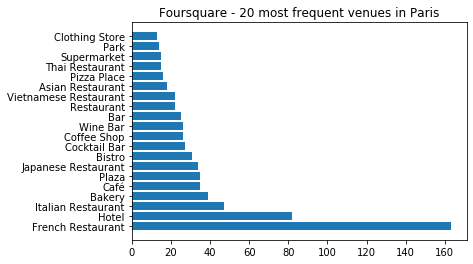

In [221]:
plt.barh(top_20['Venue Category'],top_20['Count'])
plt.title('Foursquare - 20 most frequent venues in Paris')

Text(0.5, 1.0, 'Foursquare - 20 least frequent venues in Paris')

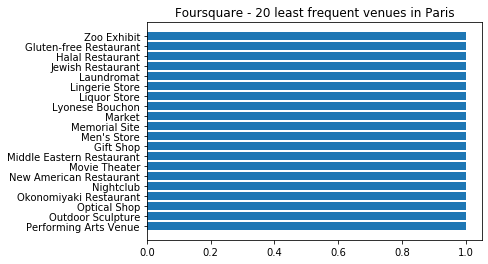

In [222]:
bottom_20 = venues_count.tail(20)
plt.barh(bottom_20['Venue Category'],bottom_20['Count'])
plt.title('Foursquare - 20 least frequent venues in Paris')

Show the number of Foursquare venues in each neighborhood.

In [223]:
venues_in_neighborhood_count = pd.DataFrame({'Count' : paris_venues.groupby( ['neighborhood'] ).size()}).reset_index().sort_values(['Count'],ascending=False)

In [224]:
venues_in_neighborhood_count

,neighborhood,Count
4,Entrepôt,100
6,Hôtel-de-Ville,100
1,Bourse,100
11,Opéra,100
12,Palais-Bourbon,100
17,Temple,92
13,Panthéon,86
7,Louvre,82
15,Popincourt,67
18,Vaugirard,61


Text(0.5, 1.0, 'Foursquare - number of venues in each Paris neighborhood')

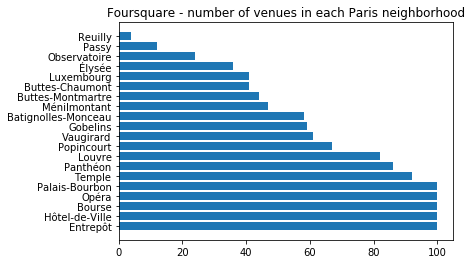

In [225]:
plt.barh(venues_in_neighborhood_count['neighborhood'],venues_in_neighborhood_count['Count'])
plt.title('Foursquare - number of venues in each Paris neighborhood')

**3.2. Split venues into Restaurants and Others**

In [226]:
restaurants = paris_venues[paris_venues["Venue Category"].str.contains("Restaurant")]
non_restaurants = paris_venues[~paris_venues["Venue Category"].str.contains("Restaurant")]

In [227]:
restaurants_summary = pd.DataFrame({'Count' : restaurants.groupby( ['Venue Category'] ).size()}).sort_values(['Count'],ascending=False).reset_index()
restaurants_summary

,Venue Category,Count
0,French Restaurant,163
1,Italian Restaurant,47
2,Japanese Restaurant,34
3,Vietnamese Restaurant,22
4,Restaurant,22
5,Asian Restaurant,18
6,Thai Restaurant,15
7,Seafood Restaurant,10
8,Chinese Restaurant,10
9,Vegetarian / Vegan Restaurant,7


I will exclude French Restaurant as this is the most frequent restaurant in Paris and also venue called just Restaurant.

In [228]:
restaurants = restaurants[~restaurants["Venue Category"].str.contains("French Restaurant")]
restaurants = restaurants[restaurants["Venue Category"] != "Restaurant"]

In [229]:
non_restaurants_summary = pd.DataFrame({'Count' : non_restaurants.groupby( ['Venue Category'] ).size()}).sort_values(['Count'],ascending=False).reset_index()
non_restaurants_summary.head(20)

,Venue Category,Count
0,Hotel,82
1,Bakery,39
2,Plaza,35
3,Café,35
4,Bistro,31
5,Cocktail Bar,27
6,Coffee Shop,26
7,Wine Bar,26
8,Bar,25
9,Pizza Place,16


**3.3. Analyze each arrondissement**

In [230]:
# one hot encoding
paris_onehot = pd.get_dummies(restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['neighborhood'] = restaurants['neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Auvergne Restaurant,Basque Restaurant,Brazilian Restaurant,Burgundian Restaurant,...,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
4,Opéra,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,Opéra,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
14,Opéra,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,Opéra,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,Opéra,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [231]:
paris_onehot.shape

(274, 57)

**3.3.1. Group rows by neighourhood and by taking the mean of the frequency of occurrence of each category.**

In [232]:
paris_grouped = paris_onehot.groupby('neighborhood').mean().reset_index()
paris_grouped

,neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Auvergne Restaurant,Basque Restaurant,Brazilian Restaurant,Burgundian Restaurant,...,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant
0,Batignolles-Monceau,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000,0.000000,0.000000,0.000000
1,Bourse,0.000000,0.000000,0.000000,0.00,0.058824,0.00,0.000000,0.000000,0.000000,...,0.058824,0.000000,0.058824,0.000000,0.117647,0.000000,0.000,0.000000,0.000000,0.000000
2,Buttes-Chaumont,0.000000,0.000000,0.166667,0.00,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.166667
3,Buttes-Montmartre,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.125000
4,Entrepôt,0.000000,0.074074,0.000000,0.00,0.074074,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.074074,0.000000,0.000,0.037037,0.000000,0.000000
5,Gobelins,0.000000,0.000000,0.000000,0.00,0.333333,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.128205,0.000000,0.000,0.000000,0.000000,0.333333
6,Hôtel-de-Ville,0.000000,0.083333,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.083333,...,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000,0.000000,0.000000,0.000000
7,Louvre,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.125,0.000000,0.000000,0.000000
8,Luxembourg,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000
9,Ménilmontant,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,...,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000


In [233]:
paris_grouped.shape

(18, 57)

**3.3.2. Print top five venues in each neighborhood.**

In [234]:
num_top_venues = 5

for hood in paris_grouped['neighborhood']:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped['neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Batignolles-Monceau----
                      venue  freq
0        Italian Restaurant  0.31
1       Japanese Restaurant  0.23
2  Mediterranean Restaurant  0.08
3        Turkish Restaurant  0.08
4     Portuguese Restaurant  0.08


----Bourse----
                 venue  freq
0  Japanese Restaurant  0.12
1      Thai Restaurant  0.12
2   Italian Restaurant  0.12
3   Mexican Restaurant  0.06
4     Sushi Restaurant  0.06


----Buttes-Chaumont----
                   venue  freq
0     Seafood Restaurant  0.33
1  Vietnamese Restaurant  0.17
2    American Restaurant  0.17
3    Japanese Restaurant  0.17
4     Italian Restaurant  0.17


----Buttes-Montmartre----
                       venue  freq
0      Vietnamese Restaurant  0.12
1         Seafood Restaurant  0.12
2  Middle Eastern Restaurant  0.12
3   Mediterranean Restaurant  0.12
4        Japanese Restaurant  0.12


----Entrepôt----
                      venue  freq
0       Japanese Restaurant  0.11
1         Indian Restaurant  0.11
2     

**3.3.3. Select 10 most common venues**

In [235]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [236]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighborhood'] = paris_grouped['neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Batignolles-Monceau,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Turkish Restaurant,Indian Restaurant,Halal Restaurant,Portuguese Restaurant,Chinese Restaurant,Falafel Restaurant,Korean Restaurant
1,Bourse,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Korean Restaurant,Greek Restaurant,Romanian Restaurant,Peruvian Restaurant,Fast Food Restaurant,Sushi Restaurant,Mexican Restaurant
2,Buttes-Chaumont,Seafood Restaurant,Italian Restaurant,Japanese Restaurant,Vietnamese Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Korean Restaurant,Jewish Restaurant,African Restaurant
3,Buttes-Montmartre,Vietnamese Restaurant,Seafood Restaurant,Fast Food Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Szechuan Restaurant,Sushi Restaurant
4,Entrepôt,Japanese Restaurant,Indian Restaurant,Mediterranean Restaurant,Asian Restaurant,Italian Restaurant,Seafood Restaurant,Korean Restaurant,African Restaurant,Thai Restaurant,Fast Food Restaurant
5,Gobelins,Vietnamese Restaurant,Asian Restaurant,Thai Restaurant,Chinese Restaurant,Japanese Restaurant,Italian Restaurant,Cambodian Restaurant,Falafel Restaurant,Korean Restaurant,Jewish Restaurant
6,Hôtel-de-Ville,Italian Restaurant,Tapas Restaurant,Scandinavian Restaurant,Israeli Restaurant,Portuguese Restaurant,Seafood Restaurant,Burgundian Restaurant,Falafel Restaurant,Jewish Restaurant,African Restaurant
7,Louvre,Japanese Restaurant,Italian Restaurant,Udon Restaurant,Thai Restaurant,Chinese Restaurant,Soba Restaurant,Corsican Restaurant,Jewish Restaurant,Israeli Restaurant,Indian Restaurant
8,Luxembourg,Italian Restaurant,Mexican Restaurant,Lebanese Restaurant,Japanese Restaurant,Latin American Restaurant,Korean Restaurant,Jewish Restaurant,Israeli Restaurant,Indian Restaurant,Halal Restaurant
9,Ménilmontant,Japanese Restaurant,Italian Restaurant,Latin American Restaurant,Mexican Restaurant,Korean Restaurant,Sushi Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Jewish Restaurant,Israeli Restaurant


#### **4. RESULTS**

**4.1. Cluster Paris neighborhoods**

Run k-means to cluster the neghbourhoods into 7 clusters.

In [237]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 7

paris_grouped_clustering = paris_grouped.drop('neighborhood',axis= 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 5, 3, 0, 0, 6, 0, 5, 2, 5], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [238]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [239]:
paris_merged = df[['Number','neighborhood Name','Latitude','Longitude']]

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('neighborhood'), on='neighborhood Name')

In [240]:
paris_merged.head()

,Number,neighborhood Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,9,Opéra,48.877164,2.337458,0.0,Vegetarian / Vegan Restaurant,Japanese Restaurant,Italian Restaurant,Vietnamese Restaurant,Chinese Restaurant,Venezuelan Restaurant,Modern European Restaurant,Falafel Restaurant,Corsican Restaurant,Seafood Restaurant
1,18,Buttes-Montmartre,48.892569,2.348161,0.0,Vietnamese Restaurant,Seafood Restaurant,Fast Food Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Szechuan Restaurant,Sushi Restaurant
2,17,Batignolles-Monceau,48.887327,2.306777,2.0,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Turkish Restaurant,Indian Restaurant,Halal Restaurant,Portuguese Restaurant,Chinese Restaurant,Falafel Restaurant,Korean Restaurant
3,20,Ménilmontant,48.863461,2.401188,5.0,Japanese Restaurant,Italian Restaurant,Latin American Restaurant,Mexican Restaurant,Korean Restaurant,Sushi Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Jewish Restaurant,Israeli Restaurant
4,15,Vaugirard,48.840085,2.292826,2.0,Italian Restaurant,Japanese Restaurant,Lebanese Restaurant,Indian Restaurant,Thai Restaurant,Seafood Restaurant,Moroccan Restaurant,Persian Restaurant,Scandinavian Restaurant,Russian Restaurant


In [241]:
paris_merged.groupby('Cluster Labels').sum()

,Number,Latitude,Longitude
Cluster Labels,,,
0.0,60,342.066579,16.494750
1.0,14,48.829245,2.326542
2.0,45,195.432717,9.244689
3.0,19,48.887076,2.384821
4.0,8,48.872721,2.312554
5.0,23,146.594303,7.080434
6.0,13,48.828388,2.362272


In [242]:
paris_merged = paris_merged.dropna()

**4.2. Visualize the resulting clusters in a map**

In [243]:
address = 'Paris'

geolocator = Nominatim(user_agent="paris_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [244]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['neighborhood Name'], paris_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**4.3. Examine Each Cluster**

In [245]:
## CLUSTER 1
paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,neighborhood Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Opéra,Vegetarian / Vegan Restaurant,Japanese Restaurant,Italian Restaurant,Vietnamese Restaurant,Chinese Restaurant,Venezuelan Restaurant,Modern European Restaurant,Falafel Restaurant,Corsican Restaurant,Seafood Restaurant
1,Buttes-Montmartre,Vietnamese Restaurant,Seafood Restaurant,Fast Food Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Szechuan Restaurant,Sushi Restaurant
5,Panthéon,Italian Restaurant,Vietnamese Restaurant,Lebanese Restaurant,Greek Restaurant,Sushi Restaurant,Ethiopian Restaurant,Mexican Restaurant,Moroccan Restaurant,Peruvian Restaurant,Portuguese Restaurant
13,Temple,Japanese Restaurant,Italian Restaurant,Vietnamese Restaurant,Chinese Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Thai Restaurant,Argentinian Restaurant,Auvergne Restaurant,Moroccan Restaurant
15,Entrepôt,Japanese Restaurant,Indian Restaurant,Mediterranean Restaurant,Asian Restaurant,Italian Restaurant,Seafood Restaurant,Korean Restaurant,African Restaurant,Thai Restaurant,Fast Food Restaurant
17,Popincourt,Vietnamese Restaurant,Italian Restaurant,Japanese Restaurant,Moroccan Restaurant,Asian Restaurant,Comfort Food Restaurant,Ethiopian Restaurant,Gluten-free Restaurant,Greek Restaurant,Korean Restaurant
18,Hôtel-de-Ville,Italian Restaurant,Tapas Restaurant,Scandinavian Restaurant,Israeli Restaurant,Portuguese Restaurant,Seafood Restaurant,Burgundian Restaurant,Falafel Restaurant,Jewish Restaurant,African Restaurant


In [246]:
## CLUSTER 2
paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,neighborhood Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Observatoire,Italian Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Venezuelan Restaurant,Latin American Restaurant,Korean Restaurant,Jewish Restaurant,Japanese Restaurant,Israeli Restaurant,Indian Restaurant


In [247]:
## CLUSTER 3
paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,neighborhood Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Batignolles-Monceau,Italian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Turkish Restaurant,Indian Restaurant,Halal Restaurant,Portuguese Restaurant,Chinese Restaurant,Falafel Restaurant,Korean Restaurant
4,Vaugirard,Italian Restaurant,Japanese Restaurant,Lebanese Restaurant,Indian Restaurant,Thai Restaurant,Seafood Restaurant,Moroccan Restaurant,Persian Restaurant,Scandinavian Restaurant,Russian Restaurant
11,Luxembourg,Italian Restaurant,Mexican Restaurant,Lebanese Restaurant,Japanese Restaurant,Latin American Restaurant,Korean Restaurant,Jewish Restaurant,Israeli Restaurant,Indian Restaurant,Halal Restaurant
14,Palais-Bourbon,Italian Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Korean Restaurant,Asian Restaurant,Basque Restaurant,New American Restaurant,Vietnamese Restaurant,Falafel Restaurant,Jewish Restaurant


In [248]:
## CLUSTER 4
paris_merged.loc[paris_merged['Cluster Labels'] == 3, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,neighborhood Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Buttes-Chaumont,Seafood Restaurant,Italian Restaurant,Japanese Restaurant,Vietnamese Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Korean Restaurant,Jewish Restaurant,African Restaurant


In [249]:
## CLUSTER 5
paris_merged.loc[paris_merged['Cluster Labels'] == 4, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,neighborhood Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Élysée,Corsican Restaurant,Italian Restaurant,Thai Restaurant,Modern European Restaurant,Mediterranean Restaurant,Argentinian Restaurant,Asian Restaurant,Korean Restaurant,Jewish Restaurant,African Restaurant


In [250]:
## CLUSTER 6
paris_merged.loc[paris_merged['Cluster Labels'] == 5, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,neighborhood Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Ménilmontant,Japanese Restaurant,Italian Restaurant,Latin American Restaurant,Mexican Restaurant,Korean Restaurant,Sushi Restaurant,Fast Food Restaurant,Ethiopian Restaurant,Jewish Restaurant,Israeli Restaurant
7,Louvre,Japanese Restaurant,Italian Restaurant,Udon Restaurant,Thai Restaurant,Chinese Restaurant,Soba Restaurant,Corsican Restaurant,Jewish Restaurant,Israeli Restaurant,Indian Restaurant
8,Bourse,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Korean Restaurant,Greek Restaurant,Romanian Restaurant,Peruvian Restaurant,Fast Food Restaurant,Sushi Restaurant,Mexican Restaurant


In [251]:
## CLUSTER 7
paris_merged.loc[paris_merged['Cluster Labels'] == 6, paris_merged.columns[[1] + list(range(5, paris_merged.shape[1]))]]

,neighborhood Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Gobelins,Vietnamese Restaurant,Asian Restaurant,Thai Restaurant,Chinese Restaurant,Japanese Restaurant,Italian Restaurant,Cambodian Restaurant,Falafel Restaurant,Korean Restaurant,Jewish Restaurant


#### **5. DISCUSSION**

As expected, most of the restaurants in Paris specialise in French cuisine. This is followed by Italian, Japanese and Vietnamese restaurants. From non-restaurant venues, very popular are bakeries, coffees, bistros and various bars.

After examining the individual clusters and looking at unique restaurants in each. Cluster 1 includes most unique types of restaurants (7). See the table below to see the unique restaurants in each of the clusters:

In [253]:
data = {'Cluster' : ['Cluster 1','Cluster 1','Cluster 1','Cluster 1','Cluster 1','Cluster 1','Cluster 1','Cluster 3','Cluster 3','Cluster 3','Cluster 3','Cluster 3','Cluster 4','Cluster 6','Cluster 6','Cluster 6','Cluster 7'],
       'Neighborhood Name': ['Buttes-Montmartre','Buttes-Montmartre','Temple','Popincourt','Popincourt','Hôtel-de-Ville','Hôtel-de-Ville','Batignolles-Monceau','Vaugirard','Vaugirard','Palais-Bourbon','Palais-Bourbon','Buttes-Chaumont','Louvre','Louvre','Bourse','Gobelins'],
       'Restaurant Type' : ['Middle Eastern Restaurant','Szechuan Restaurant','Auvergne Restaurant','Comfort Food Restaurant','Gluten-free Restaurant','Tapas Restaurant','Burgundian Restaurant','Turkish Restaurant','Persian Restaurant','Russian Restaurant','Basque Restaurant','New American Restaurant','American Restaurant','Udon Restaurant','Soba Restaurant','Romanian Restaurant','Cambodian Restaurant'],
       'Rank in Neighborhood' : ['7th','9th','9th','6th','8th','2nd','7th','4th','8th','10th','6th','7th','5th','3rd','6th','6th','7th']}

In [255]:
unique_venues = pd.DataFrame(data, columns = ['Cluster','Neighborhood Name','Restaurant Type','Rank in Neighborhood'])
unique_venues

,Cluster,Neighborhood Name,Restaurant Type,Rank in Neighborhood
0,Cluster 1,Buttes-Montmartre,Middle Eastern Restaurant,7th
1,Cluster 1,Buttes-Montmartre,Szechuan Restaurant,9th
2,Cluster 1,Temple,Auvergne Restaurant,9th
3,Cluster 1,Popincourt,Comfort Food Restaurant,6th
4,Cluster 1,Popincourt,Gluten-free Restaurant,8th
5,Cluster 1,Hôtel-de-Ville,Tapas Restaurant,2nd
6,Cluster 1,Hôtel-de-Ville,Burgundian Restaurant,7th
7,Cluster 3,Batignolles-Monceau,Turkish Restaurant,4th
8,Cluster 3,Vaugirard,Persian Restaurant,8th
9,Cluster 3,Vaugirard,Russian Restaurant,10th


Apart from type of the venue in the neighborhood, it is recommended to look at other aspects of the neighborhoods, such as retail rental prices and where people and tourists visiting Paris spent most of their time and when.

#### **6. CONCLUSION**

There are various cuisines offered in Paris that tourist can taste. This analysis shows what types of restaurants can be found in Paris and in what neighborhood.